In [ ]:
#|default_exp cnn_virus.data

In [ ]:
#|hide
from __future__ import annotations
from ecutilities.ipython import nb_setup
from fastcore.test import test_fail
from nbdev import show_doc, nbdev_export
from pprint import pprint

import numpy as np

In [ ]:
#| hide
nb_setup()

# ON_COLAB, p2dataroot, p2data = setup_nb(_dev=True)

Set autoreload mode


In [ ]:
#|export
from ecutilities.core import validate_path
from functools import partial, partialmethod
from metagentools.bio import q_score2prob_error
from metagentools.core import TextFileBaseIterator
from pathlib import Path
from typing import Any, Optional

import json
import numpy as np
import re
import tensorflow as tf

In [ ]:
#|hide
print(f"Tensorflow version: {tf.__version__} - Expected 2.8.2")

Tensorflow version: 2.8.2 - Expected 2.8.2


# data

> Data preprocessing functions, data loaders, ...

# Data structure for CNN Virus project

The following diagram shows the different types of data from raw data to processed data to data used by the CNN Virus model

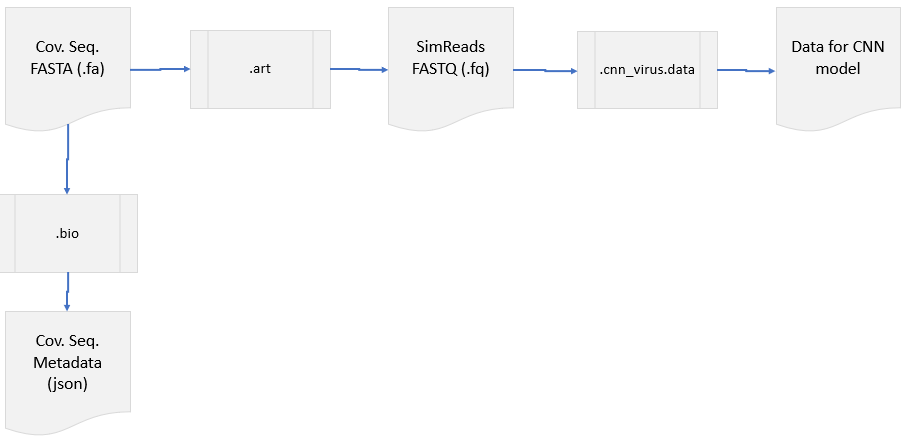

## Corona Virus Sequence Files

All cov sequence are available as FASTA files.

Examples of corona virus sequence files (fasta) with different number of sequences used in the project:
```
data
  |--cov_data
  |    |--cov_virus_sequences_hundred.fa
  |    |--cov_virus_sequence_one_2.fa
  |    |--cov_virus_sequences_two.fa
  |    |--cov_virus_sequences_twenty_five.fa
  |    |--cov_virus_sequences_ten.fa
  |    |--cov_virus_sequence_one_1.fa
  |    |--cov_virus_sequences.fa
```

Those fasta files have the following format (showing 5 sequences):
```
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D	scient
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTA ...
>11128:ncbi:2 [LC494191]
CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCCTATGGGCGTAGATTTTTCATAGTGGTGTCT ...
>31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43	scientific name
ATCTCTTGTTAGATCTTTTTGTAATCTAAACTTTATAAAAACATCCACTCCCTGTAATCTATGCTTGTGGGCGTAGATTTTTCATAGTGGTGTTTATATTCATTTCTGCT ...
>277944:ncbi:4 [LC654455]	277944	ncbi	4 [LC654455] 277944	Human coronavirus NL63	scientific name
ATTTTCTTATTTAGACTTTGTGTCTACTCTTCTCAACTAAACGAAATTTTTCTAGTGCTGTCATTTGTTATGGCAGTCCTAGTGTAATTGAAATTTCGTCAAGTTTGTAA ...
>11120:ncbi:5 [MN987231]	11120	ncbi	5 [MN987231] 11120	Infectious bronchitis virus	scientific name
TCCTAAGTGTGATATAAATATATATCATACACACTAGCCTTGCGCTAGATTTCTAACTTAACAAAACGGACTTAAATACCTACAGCTGGTCCCTATAGGTGTTCCATTGC ...
....
```

In this format, a *Definition Lines* includes the following **metadata**:

- `SeqID`, a unique ID for the sequence
- `source`, the source of the sequence
- `seq_nbr`, the number/position of the sequence in the file
- `accession`, another idenfifier for the sequence on NCBI
- `species`, a full name for the sequence, sometimes this information is missing.

Example 1:

- Definition Line:
```ascii
    >2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name
```
- Metadata:
    - `SeqID` = `2591237`
    - `source` = `ncbi`
    - `seq_nbr` = `1`
    - `accession` = `MK211378`
    - `species` = `Coronavirus BtRs-BetaCoV/YN2018D`

Example 2:

- Definition Line
```ascii
    >11128:ncbi:2 [LC494191]
```

- Metadata:
    - `SeqID` = `11128`
    - `source` = `ncbi`
    - `seq_nbr` = `2`
    - `accession` = `LC494191`
    - `species` = `''`

## Simulated Read Files

Simulated reads information is split between two files:

- FASTQ (`.fq`) files providing the read sequences and their ASCII quality scores
- ALN (`.aln`) files with alignment information

Example of read sequence FASTA and ALN files used in this project

```ascii
data
  |--cov_simreads
  |    |--single_25seq_50bp
  |    |    |--single_25seq_50bp.aln
  |    |    |--single_25seq_50bp.fq
  |    |--single_25seq_150bp
  |    |    |--single_25seq_150bp.fq
  |    |    |--single_25seq_150bp.aln
  |    |--single_100seq_50bp
  |    |    |--single_100seq_50bp.fq
  |    |    |--single_100seq_50bp.aln
  |    |--single_100seq_150bp
  |    |    |--single_100seq_150bp.fq
  |    |    |--single_100seq_150bp.aln
  ```

**FASTQ** (`.fq`) files generated by ART Illumina have the following structure (showing 5 reads):

```ascii
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
@2591237:ncbi:1-60399
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
+
BCBCCFGGGGGGGG1CGGGG<GGBGGGGGFGCGGGGGGDGGG/GG1GGGG
@2591237:ncbi:1-60398
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
+
CCCCCGGGEGG1GGF1G/GGEGGGGGGGGGGGGFFGGGGGGGGGGDGGDG
@2591237:ncbi:1-60397
CGTAAAGTAGAGGCTGTATGGTAGCTAGCACAAATGCCAGCACCAATAGG
+
BCCCCGGGFGGGGGGFGGGGFGG1GGGGGGG>GG1GGGGGGGGGGE<GGG
@2591237:ncbi:1-60396
GGTATCGGGTATCTCCTGCATCAATGCAAGGTCTTACAAAGATAAATACT
+
CBCCCGGG@CGGGGGGGGGGGG=GFGGGGDGGGFG1GGGGGGGG@GGGGG
```

The following information can be parsed from the each read sequence in the FASTQ file:

- Line 1: `readid`, a unique ID for the read, under for format `@read_id` 
- Line 2: `sequence`, the sequence of the read
- Line 3: a separator `+`
- Line 4: `q scores`, the base quality scores encoded in ASCII 

Example:
```
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```
- `readid` = `2591237:ncbi:1-60400`
- `sequence` = `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`, a 50 bp read
- `q scores` = `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`

**ALN** (`.aln`) files generated by ART Illumina have the following structure (showing 5 reads):

```ascii
##ART_Illumina	read_length	50
@CM	/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/cov_data/cov_virus_sequences_ten.fa -ss HS25 -l 50 -f 100 -o /home/vtec/projects/bio/metagentools/data/cov_simreads/single_10seq_50bp/single_10seq_50bp -rs 1674660835
@SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name	30213
@SQ	11128:ncbi:2 [LC494191]	11128	ncbi	2 [LC494191] 11128	Bovine coronavirus		scientific name	30942
@SQ	31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43		scientific name	30661
@SQ	277944:ncbi:4 [LC654455]	277944	ncbi	4 [LC654455] 277944	Human coronavirus NL63		scientific name	27516
@SQ	11120:ncbi:5 [MN987231]	11120	ncbi	5 [MN987231] 11120	Infectious bronchitis virus		scientific name	27617
@SQ	28295:ncbi:6 [KU893866]	28295	ncbi	6 [KU893866] 28295	Porcine epidemic diarrhea virus		scientific name	28043
@SQ	28295:ncbi:7 [KJ645638]	28295	ncbi	7 [KJ645638] 28295	Porcine epidemic diarrhea virus		scientific name	27998
@SQ	28295:ncbi:8 [KJ645678]	28295	ncbi	8 [KJ645678] 28295	Porcine epidemic diarrhea virus		scientific name	27998
@SQ	28295:ncbi:9 [KR873434]	28295	ncbi	9 [KR873434] 28295	Porcine epidemic diarrhea virus		scientific name	28038
@SQ	1699095:ncbi:10 [KT368904]	1699095	ncbi	10 [KT368904] 1699095	Camel alphacoronavirus		scientific name	27395
##Header End
>2591237:ncbi:1	2591237:ncbi:1-60400	14770	+
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
>2591237:ncbi:1	2591237:ncbi:1-60399	17012	-
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
>2591237:ncbi:1	2591237:ncbi:1-60398	9188	+
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
>2591237:ncbi:1	2591237:ncbi:1-60397	6764	-
CGTAAAGTAGAGGCTGTATGGTAGCTAGCACAAATGCCAGCACCAATAGG
CGTAAAGTAGAGGCTGTATGGTAGCTAGCACAAATGCCAGCACCAATAGG
>2591237:ncbi:1	2591237:ncbi:1-60396	27357	+
GGTATCGGGTATCTCCTGCATCAATGCAAGGTCTTACAAAGATAAATACT
GGTATCGGGTATCTCCTGCATCAATGCAAGGTCTTACAAAGATAAATACT
.....
```

ALN files consist of 

- a header with the simulation ART command and information about the reference full sequences used for the simulations
- the body with three lines for each read:
    - definition line with `readid`, 
    - reference sequence `seqid', 
    - the position in the read in the reference sequence 'aln_start_pos' 
    - the 'ref_seq_strand'

In [ ]:
#| hide
# p2aln = Path('../data/cov_simreads/single_10seq_50bp/single_10seq_50bp.aln').resolve()
# it = TextFileBaseIterator(p2aln, nlines=30)
# it.print_first_chuncks(1)

# Parsing sequence files

The following classes and functions make it easier to read and parse files of different format into their underlying components to generated the training, validation, testing and inference datasets for the model.

- File Iterators: classes to read the file chunch by chunch and handle basic underlying components.
- Parsing Functions: function taking the output of a File Iterator and extracting the metadata from the relevant element under the form or a key:value dictionary
- File Readers: classes reading in a specific file and using file iterators and parsing functions to give access to the underlying data in different format, either as an iterator or as a full dataset dictionary

## FASTA file

In [ ]:
#| export
class FastaFileIterator(TextFileBaseIterator):
    """Iterator going through a fasta file sequence by sequence and returning definition line and sequence as a dict"""
    def __init__(
        self,
        path:str|Path,   # path to the fasta file
    ):
        super().__init__(path, nlines=1)
    
    def __next__(self)-> dict[str, str]:   # `{'definition line': text in dfn line, 'sequence': full sequence as str}` 
        """Return one definition line and the corresponding sequence"""
        lines = []
        for i in range(2):
            lines.append(self._safe_readline())
        dfn_line = lines[0]
        sequence = lines[1].replace('\n', '')
        return {'definition line':dfn_line, 'sequence':f"{sequence}"}
    
    def print_first_chuncks(
        self, 
        nchunks:int=3,  # number of chunks to print out
    ):
        """Print the first `nchunks` chuncks of text from the file"""
        for i, seq_dict in enumerate(self.__iter__()):
            print(f"\nSequence {i+1}:")
            print(seq_dict['definition line'])
            print(f"{seq_dict['sequence'][:80]} ...")
            if i >= nchunks: break

In [ ]:
show_doc(FastaFileIterator)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L22){target="_blank" style="float:right; font-size:smaller"}

### FastaFileIterator

>      FastaFileIterator (path:str|pathlib.Path)

Iterator going through a fasta file sequence by sequence and returning definition line and sequence as a dict

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the fasta file |

At each iteration, `FastaFileIterator` returns a `dict` as follows:
```python
{
    'definition line': 'string in file as the definition line for the sequence',
    'sequence': 'the full sequence'
}
```

Example:

In [ ]:
p2fasta = Path('data_dev/cov_virus_sequences_two.fa')

it = FastaFileIterator(p2fasta)
iteration_output = next(it)

print(f"output type .... {type(iteration_output)}")
print(f"keys ........... {iteration_output.keys()}")
print(f"definition line  '{iteration_output['definition line'][:-1]}'")
print(f"sequence ....... '{iteration_output['sequence'][:100]} ...'")

output type .... <class 'dict'>
keys ........... dict_keys(['definition line', 'sequence'])
definition line  '>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name'
sequence ....... 'TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGC ...'


In [ ]:
show_doc(FastaFileIterator.print_first_chuncks)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L39){target="_blank" style="float:right; font-size:smaller"}

### FastaFileIterator.print_first_chuncks

>      FastaFileIterator.print_first_chuncks (nchunks:int=3)

Print the first `nchunks` chuncks of text from the file

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nchunks | int | 3 | number of chunks to print out |

Allows to quickly discover new fasta files:

In [ ]:
it = FastaFileIterator(p2fasta)
it.print_first_chuncks(nchunks=2)


Sequence 1:
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name

TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT ...

Sequence 2:
>11128:ncbi:2 [LC494191]

CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCC ...


In [ ]:
#| export
def base_metadata_parser(
    txt:str,         # string to parse
    pattern:str,     # regex pattern to apply to parse the string
    keys:list[str],  # list of keys: keys are both the regex match group names and the corresponding output dict keys
)-> dict:            # parsed metadata in key/value format
    """Basic parser fn parsing metadata from string, using regex pattern and return a metadata dictionary"""
    matches = re.match(pattern, txt)
    metadata = {}
    if matches is not None:
        for g in keys:
            m = matches.group(g)
            metadata[g] = m.replace('\t', ' ').strip() if m is not None else None
        return metadata
    else:
        raise ValueError(f"No match on this line")

In [ ]:
show_doc(base_metadata_parser)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L51){target="_blank" style="float:right; font-size:smaller"}

### base_metadata_parser

>      base_metadata_parser (txt:str, pattern:str, keys:list[str])

Basic parser fn parsing metadata from string, using regex pattern and return a metadata dictionary

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| txt | str | string to parse |
| pattern | str | regex pattern to apply to parse the string |
| keys | list[str] | list of keys: keys are both the regex match group names and the corresponding output dict keys |
| **Returns** | **dict** | **parsed metadata in key/value format** |

Set up the pattern and keys for parsing

In [ ]:
pattern = r"^>(?P<seqid>\d+):(?P<source>ncbi):(?P<seq_nbr>\d*)(\s*|\t*)\[(?P<accession>\w*\d*)\](\s*\n|((\s*|\t)(?P=seqid))(\s*|\t)(?P=source)(\s*|\t)\d*(\s*|\t)\[(?P=accession)\](\s*|\t)(?P=seqid)(\s*|\t)(?P<species>.*)(\s*|\t)scientific name\s*\n)"

keys = 'seqid accession seq_nbr species'.split(' ')

Running the parser function on a FASTA definition line used in this project

In [ ]:
it = FastaFileIterator(p2fasta)
dfn_line, sequence = next(it).values()
print(dfn_line.replace('\n', ''))

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name


In [ ]:
base_metadata_parser(dfn_line, pattern=pattern, keys=keys)

{'seqid': '2591237',
 'accession': 'MK211378',
 'seq_nbr': '1',
 'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}

In [ ]:
#| export
def parse_metadata_fasta_cov(
    txt:str,                       # definition line in covid sequence fasta file
    pattern:Optional[str]=None,    # regex pattern to apply to parse the definition line
    keys: Optional[list[str]]=None # list of keys: keys are both the regex match group names and the corresponding output dict keys
)-> dict:                          # parsed metadata in key/value format
    """Parse metadata from one sequence definition line and return a metadata dictionary
    
    By default, `pattern` and `keys` are set to match the format of the project cov sequences
    """
    if pattern is None:
        pattern = r"^>(?P<seqid>\d+):(?P<source>ncbi):(?P<seq_nbr>\d*)(\s*|\t*)\[(?P<accession>\w*\d*)\](\s*\n|((\s*|\t)(?P=seqid))(\s*|\t)(?P=source)(\s*|\t)\d*(\s*|\t)\[(?P=accession)\](\s*|\t)(?P=seqid)(\s*|\t)(?P<species>.*)(\s*|\t)scientific name\s*\n)"
    if keys is None: keys = 'seqid accession seq_nbr species'.split(' ')
    return base_metadata_parser(txt, pattern, keys)

In [ ]:
show_doc(parse_metadata_fasta_cov)

---

### parse_metadata_fasta_cov

>      parse_metadata_fasta_cov (txt:str, pattern:Optional[str]=None,
>                                keys:Optional[list[str]]=None)

Parse metadata from one sequence definition line and return a metadata dictionary

By default, `pattern` and `keys` are set to match the format of the project cov sequences

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | definition line in covid sequence fasta file |
| pattern | Optional[str] | None | regex pattern to apply to parse the definition line |
| keys | Optional[list[str]] | None | list of keys: keys are both the regex match group names and the corresponding output dict keys |
| **Returns** | **dict** |  | **parsed metadata in key/value format** |

In [ ]:
it = FastaFileIterator(p2fasta)
dfn_line, sequence = next(it).values()
print(f"definition line: '{dfn_line[:-1]}'")

definition line: '>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name'


In [ ]:
parse_metadata_fasta_cov(dfn_line)

{'seqid': '2591237',
 'accession': 'MK211378',
 'seq_nbr': '1',
 'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}

In [ ]:
#| export
class FastaMetadataIterator(FastaFileIterator):
    """Parse all definition lines in a FASTA file for metadata"""
    def get_metadata(
        self,
        save_json:bool=False  # save metadata as json if True
    )-> dict: # key/value where key is SeqID and value is metadata `dict`
        """returns metadata as a dictionary and optionally save as json next to original fasta file:

        - keys are the `SeqID` for each sequence in the fasta file
        - values are `dict` with parsed metadata from the corresponding sequence definition line
        """       
        fasta_metadata = {}
        for o in self.__iter__():
            dfn_line = o['definition line']
            seq_metadata = parse_metadata_fasta_cov(dfn_line)
            fasta_metadata[seq_metadata['seqid']] = seq_metadata
        
        if save_json:
            p2json = self.path.parent / f"{self.path.stem}_metadata.json"
            with open(p2json, 'w') as fp:
                json.dump(fasta_metadata, fp, indent=4)
                print(f"Metadata for '{self.path.name}'> saved as <{p2json.name}> in  \n{p2json.parent.absolute()}\n")
            
        return fasta_metadata

In [ ]:
show_doc(FastaMetadataIterator.get_metadata)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L85){target="_blank" style="float:right; font-size:smaller"}

### FastaMetadataIterator.get_metadata

>      FastaMetadataIterator.get_metadata (save_json:bool=False)

returns metadata as a dictionary and optionally save as json next to original fasta file:

- keys are the `SeqID` for each sequence in the fasta file
- values are `dict` with parsed metadata from the corresponding sequence definition line

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| save_json | bool | False | save metadata as json if True |
| **Returns** | **dict** |  | **key/value where key is SeqID and value is metadata `dict`** |

In [ ]:
it = FastaMetadataIterator(p2fasta)
meta = it.get_metadata(save_json=False)
pprint(meta)

{'11128': {'accession': 'LC494191',
           'seq_nbr': '2',
           'seqid': '11128',
           'species': None},
 '2591237': {'accession': 'MK211378',
             'seq_nbr': '1',
             'seqid': '2591237',
             'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}}


In [ ]:
it = FastaMetadataIterator(p2fasta)
meta = it.get_metadata(save_json=True)
pprint(meta)

Metadata for 'cov_virus_sequences_two.fa'> saved as <cov_virus_sequences_two_metadata.json> in  
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev

{'11128': {'accession': 'LC494191',
           'seq_nbr': '2',
           'seqid': '11128',
           'species': None},
 '2591237': {'accession': 'MK211378',
             'seq_nbr': '1',
             'seqid': '2591237',
             'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}}


In [ ]:
p2fasta = Path('data_dev/cov_virus_sequence_one.fa').resolve()
it = FastaMetadataIterator(p2fasta)
meta = it.get_metadata(save_json=True)
pprint(meta)

Metadata for 'cov_virus_sequence_one.fa'> saved as <cov_virus_sequence_one_metadata.json> in  
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev

{'2591237': {'accession': 'MK211378',
             'seq_nbr': '1',
             'seqid': '2591237',
             'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}}


In [ ]:
#| export
class FastaFileReader:
    """Wrap a FASTA file and retrieve its contend in raw format and parsed format"""
    def __init__(
        self,
        path: str|Path,  # path to the Fasta file
    ):
        validate_path(path, raise_error=True)
        self.path = path
        self.it = None
        self.reset_iterator()
        
    def reset_iterator(self):
        """Reset the iterator to first file line"""
        self.it = FastaFileIterator(self.path)
        
    def parse_fasta(
        self,
        add_seq:bool=False,    # Add the full sequence to the parsed dictionary when True
    )-> dict[str]:              # Key/Values for keys: `seqid`, `seq_nbr`, `accession`, `species` and optionaly `sequence`
        """Read fasta file and return a dictionary with definition line metadata and optionally sequences"""
        self.reset_iterator()
        parsed = {}
        for d in self.it:
            dfn_line = d['definition line']
            seq = d['sequence']
            metadata = parse_metadata_fasta_cov(dfn_line)
            if add_seq: metadata['sequence'] = seq         
            parsed[metadata['seqid']] = metadata
        return parsed

In [ ]:
show_doc(FastaFileReader)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L109){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader

>      FastaFileReader (path:str|pathlib.Path)

Wrap a FASTA file and retrieve its contend in raw format and parsed format

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the Fasta file |

In [ ]:
fasta = FastaFileReader(p2fasta)

In [ ]:
for d in fasta.it:
    print(d['definition line'])

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name



In [ ]:
show_doc(FastaFileReader.reset_iterator)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L120){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader.reset_iterator

>      FastaFileReader.reset_iterator ()

Reset the iterator to first file line

Once the iterator is consumed, it no longer can be used:

In [ ]:
try:
    for d in fasta.it:
        print(d['definition line'])
except ValueError as e:
    print(e)

I/O operation on closed file.


In [ ]:
#| hide
def test_fn():
    for d in fasta.it:
        print(d['definition line'])
test_fail(test_fn, msg='should raise a ValueError', contains='I/O operation on closed file.')

`reset_iterator` resets the iterator so that it can be consumed again

In [ ]:
fasta.reset_iterator()
for d in fasta.it:
    print(d['definition line'])

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name



In [ ]:
show_doc(FastaFileReader.parse_fasta)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L124){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader.parse_fasta

>      FastaFileReader.parse_fasta (add_seq:bool=False)

Read fasta file and return a dictionary with definition line metadata and optionally sequences

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| add_seq | bool | False | Add the full sequence to the parsed dictionary when True |
| **Returns** | **dict[str]** |  | **Key/Values for keys: `seqid`, `seq_nbr`, `accession`, `species` and optionaly `sequence`** |

In [ ]:
parsed_fasta = fasta.parse_fasta()
parsed_fasta

{'2591237': {'seqid': '2591237',
  'accession': 'MK211378',
  'seq_nbr': '1',
  'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}}

In [ ]:
parsed_fasta_with_sequences = fasta.parse_fasta(add_seq=True)
for k, v in parsed_fasta_with_sequences.items():
    print(k)
    print(v.keys())

2591237
dict_keys(['seqid', 'accession', 'seq_nbr', 'species', 'sequence'])


## FASTQ file

In [ ]:
#| hide
p2fastq = Path('data_dev/single_1seq_150bp/single_1seq_150bp.fq').resolve()
it = TextFileBaseIterator(p2fastq, nlines=4)
it.print_first_chuncks(nchunks=3)

4-line chunk 1
@2591237:ncbi:1-20100
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA
+
CCC1=GGGGGGGGJJJGCGJJJGCJCJJJGGGG=GGJJJJCGGGJJCJ1GJJGJC1J8GGCJGGJJGGJGGJGGGGGGGGG8G=GGCGGGCGCGGCGCGGJCGGC=CGGGGGGCGGCGGGCGGGGCGGGGCG81CC=G=GGGCCGGGCGC

4-line chunk 2
@2591237:ncbi:1-20099
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTTGAAGGTGTTAAACCTTTAACTGAACCTTCTGTTATTAAAACACCATTACGGGCATTTCTATAAAGGTCTA
+
CCCGGCGCGGGGGJJCJJGGCCJJGJJJGCJJGJJG1GGGJJCJJ(JGJGGJGJCGJGGCJJG=JGGJGGCGCCGGCG8GGGGCGGGCCCG(8C=GGCGGJGCC8G=CG=8CGGG=CCGGGGGGCGCGG=CGGG8GG=CGCCCGGGGGGC

4-line chunk 3
@2591237:ncbi:1-20098
AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAATCGCTCATTGACCTCCAAGAACTTGGTAAATATGAGCAATACATCAAATGGCCCTGGTACGTTTGGCTCGGCTTCATTGCTGGACTGATTGCTATCGTTATGGCC
+
CCC1GG=CGGGGGCCGJGJJJJJJJJJJJ=J1JGCGJCGGJJCGJGGGGCJGJGCGGJJJJGJGGJGGJJGGGGJGJGJGGGGCCGGGGGCGG=GGGGGGJCGCCG1CGGGGGCGGCGCGGG=GGG

In [ ]:
#| export
class FastqFileIterator(TextFileBaseIterator):
    """Iterator going through a fastq file's sequences and return each section + prob error as a dict"""
    def __init__(
        self,
        path:str|Path,   # path to the fastq file
    )-> dict:           # key/value with keys: definition line; sequence; q score; prob error
        self.nlines = 4
        super().__init__(path, nlines=self.nlines)
    
    def __next__(self):
        """Return definition line, sequence and quality scores"""
        lines = []
        for i in range(self.nlines):
            lines.append(self._safe_readline().replace('\n', ''))
        
        output = {
            'definition line':lines[0], 
            'sequence':f"{lines[1]}", 
            'q scores': f"{lines[3]}",
        }
        
        output['prob error'] = np.array([q_score2prob_error(q) for q in output['q scores']])
        
        return output
    
#     def print_first_chuncks(
#         self, 
#         nchunks:int=3,  # number of chunks to print out
#     ):
#         """Print the first `nchunks` chuncks of text from the file"""
#         for i, seq_dict in enumerate(self.__iter__()):
#             print(f"\nSequence {i+1}:")
#             print(seq_dict['definition line'])
#             print(f"{seq_dict['sequence'][:80]} ...")
#             if i >= nchunks: break

In [ ]:
show_doc(FastqFileIterator)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L140){target="_blank" style="float:right; font-size:smaller"}

### FastqFileIterator

>      FastqFileIterator (path:str|pathlib.Path)

Iterator going through a fastq file's sequences and return each section + prob error as a dict

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the fastq file |
| **Returns** | **dict** | **key/value with keys: definition line; sequence; q score; prob error** |

In [ ]:
it = FastqFileIterator(p2fastq)
iteration_output = next(it)

print(type(iteration_output))
print(iteration_output.keys())
print(f"Definition line:  {iteration_output['definition line']}")
print(f"Read sequence:    {iteration_output['sequence']}")
print(f"Q scores (ASCII): {iteration_output['q scores']}")
print(f"Prob error:       {','.join([f'{p:.4f}' for p in iteration_output['prob error']])}")

<class 'dict'>
dict_keys(['definition line', 'sequence', 'q scores', 'prob error'])
Definition line:  @2591237:ncbi:1-20100
Read sequence:    GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA
Q scores (ASCII): CCC1=GGGGGGGGJJJGCGJJJGCJCJJJGGGG=GGJJJJCGGGJJCJ1GJJGJC1J8GGCJGGJJGGJGGJGGGGGGGGG8G=GGCGGGCGCGGCGCGGJCGGC=CGGGGGGCGGCGGGCGGGGCGGGGCG81CC=G=GGGCCGGGCGC
Prob error:       0.0004,0.0004,0.0004,0.0251,0.0016,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0.0002,0.0004,0.0002,0.0001,0.0001,0.0001,0.0002,0.0004,0.0001,0.0004,0.0001,0.0001,0.0001,0.0002,0.0002,0.0002,0.0002,0.0016,0.0002,0.0002,0.0001,0.0001,0.0001,0.0001,0.0004,0.0002,0.0002,0.0002,0.0001,0.0001,0.0004,0.0001,0.0251,0.0002,0.0001,0.0001,0.0002,0.0001,0.0004,0.0251,0.0001,0.0050,0.0002,0.0002,0.0004,0.0001,0.0002,0.0002,0.0001,0.0001,0.0002,0.0002,0.0001,0.0002,0.0002,0.0001,0.0002,0.0002,0.

Five largest probabilities of error:

In [ ]:
np.sort(iteration_output['prob error'])[-5:]

array([0.00501187, 0.02511886, 0.02511886, 0.02511886, 0.02511886])

In [ ]:
np.argsort(iteration_output['prob error'])[-5:]

array([ 81,  48,   3,  55, 133])

In [ ]:
#| export
def parse_metadata_art_reads(
    txt:str,                   # definition line in ART read definition line
    pattern:str|None=None,     # regex pattern to apply to parse the definition line
    keys:list[str]|None=None,  # list of keys: keys are both regex match group names and corresponding output dict keys 
)->dict[str]:                  # parsed metadata in key/value format
    """Parse metadata from one read definition line and return a metadata dictionary

    By default, pattern and keys are set to match the output format of ART Illumina simulated reads"""
    if pattern is None:
        pattern = r"^@(?P<readid>(?P<seqid>\d*):(?P<source>\w*):(?P<seq_nbr>\d*)-(?P<read_nbr>\d*))$"
    if keys is None: keys = 'readid seqid source seq_nbr read_nbr'.split(' ')
    return base_metadata_parser(txt, pattern, keys)

In [ ]:
show_doc(parse_metadata_art_reads)

---

### parse_metadata_art_reads

>      parse_metadata_art_reads (txt:str, pattern:str|None=None,
>                                keys:list[str]|None=None)

Parse metadata from one read definition line and return a metadata dictionary

By default, pattern and keys are set to match the output format of ART Illumina simulated reads

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | definition line in ART read definition line |
| pattern | str \| None | None | regex pattern to apply to parse the definition line |
| keys | list[str] \| None | None | list of keys: keys are both regex match group names and corresponding output dict keys |
| **Returns** | **dict[str]** |  | **parsed metadata in key/value format** |

In [ ]:
dfn_line = iteration_output['definition line']
meta = parse_metadata_art_reads(dfn_line)
meta

{'readid': '2591237:ncbi:1-20100',
 'seqid': '2591237',
 'source': 'ncbi',
 'seq_nbr': '1',
 'read_nbr': '20100'}

In [ ]:
#| export
class FastqFileReader:
    """Wrap a FASTQ file and retrieve its content in raw format and parsed format"""
    def __init__(
        self,
        path: str|Path,  # path to the Fastq file
    ):
        validate_path(path, raise_error=True)
        self.path = path
        self.it = None
        self.reset_iterator()
        
    def reset_iterator(self):
        """Reset the iterator to first file line"""
        self.it = FastqFileIterator(self.path)
        
    def parse_fastq(
        self, 
        add_seq:bool=False,        # Add the read sequence to the parsed dictionary when True
        add_q_scores:bool=False,    # Add the read ASCII Q Scores to the parsed dictionary when True
        add_prob_error:bool=False  # Add the read probability of error to the parsed dictionary when True
    )-> dict[str]: # Key/Values. Keys: `seqid`,`seq_nbr`,`accession`,`species`; optionaly 'sequence','q scores','prob error'
        """Read fasta file and return a dictionary with definition line metadata and optionally sequences, Q scores and prop error"""
        self.reset_iterator()
        parsed = {}
        for d in self.it:
            dfn_line = d['definition line']
#             print(dfn_line)
            seq, q_scores, prob_e = d['sequence'], d['q scores'], d['prob error']
            metadata = parse_metadata_art_reads(dfn_line)
            if add_seq: metadata['sequence'] = seq         
            if add_q_scores: metadata['q scores'] = q_scores
            if add_prob_error: metadata['prob error'] = prob_e
            parsed[metadata['readid']] = metadata 
        return parsed

In [ ]:
show_doc(FastqFileReader)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L191){target="_blank" style="float:right; font-size:smaller"}

### FastqFileReader

>      FastqFileReader (path:str|pathlib.Path)

Wrap a FASTQ file and retrieve its content in raw format and parsed format

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the Fastq file |

In [ ]:
fastq = FastqFileReader(p2fastq)
next(fastq.it).keys()

dict_keys(['definition line', 'sequence', 'q scores', 'prob error'])

In [ ]:
show_doc(FastqFileReader.parse_fastq)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L206){target="_blank" style="float:right; font-size:smaller"}

### FastqFileReader.parse_fastq

>      FastqFileReader.parse_fastq (add_seq:bool=False, add_q_scores:bool=False,
>                                   add_prob_error:bool=False)

Read fasta file and return a dictionary with definition line metadata and optionally sequences, Q scores and prop error

In [ ]:
parsed = fastq.parse_fastq()
for i, (k, v) in enumerate(parsed.items()):
    print(k)
    pprint(v)
    if i >=3: break

2591237:ncbi:1-20100
{'read_nbr': '20100',
 'readid': '2591237:ncbi:1-20100',
 'seq_nbr': '1',
 'seqid': '2591237',
 'source': 'ncbi'}
2591237:ncbi:1-20099
{'read_nbr': '20099',
 'readid': '2591237:ncbi:1-20099',
 'seq_nbr': '1',
 'seqid': '2591237',
 'source': 'ncbi'}
2591237:ncbi:1-20098
{'read_nbr': '20098',
 'readid': '2591237:ncbi:1-20098',
 'seq_nbr': '1',
 'seqid': '2591237',
 'source': 'ncbi'}
2591237:ncbi:1-20097
{'read_nbr': '20097',
 'readid': '2591237:ncbi:1-20097',
 'seq_nbr': '1',
 'seqid': '2591237',
 'source': 'ncbi'}


## ALN Alignment Files

In [ ]:
#| export
class AlnFileIterator(TextFileBaseIterator):
    """Iterator going through aln file"""
    def __init__(
        self,
        path:str|Path,   # path to the aln file
    )-> dict:            # key/value with keys: 
        self.nlines = 1
        super().__init__(path, nlines=self.nlines)
        self.header = self.read_header()
        self.nlines = 3
    
    def __next__(self):
        """Return definition line, sequence and quality scores"""
        lines = []
        for i in range(self.nlines):
            lines.append(self._safe_readline().replace('\n', ''))

        output = {
            'definition line':lines[0], 
            'ref_seq_aligned':f"{lines[1]}", 
            'read_seq_aligned': f"{lines[2]}",
        }   
        return output
    
    def read_header(self):
        """Read ALN file Header and return a each section parsed in a dictionary"""
        
        header = {}
        line = self._safe_readline().replace('\n', '')
        if not line.startswith('##ART_Illumina'): 
            raise ValueError(f"Header of this file does not start with ##ART_Illumina")
        line = self._safe_readline().replace('\n', '')
        if not line.startswith('@CM'): 
            raise ValueError(f"First header line should start with @CM")
        else: 
            header['command'] = line[3:].replace('\t', '').strip()

        refseqs = []
        while True:
            line = self._safe_readline().replace('\n', '')
            if line.startswith('##Header End'): break
            else:
                refseqs.append(line)
        header['reference sequences'] = refseqs
        
        return header
            
    
#     def print_first_chuncks(
#         self, 
#         nchunks:int=3,  # number of chunks to print out
#     ):
#         """Print the first `nchunks` chuncks of text from the file"""
#         for i, seq_dict in enumerate(self.__iter__()):
#             print(f"\nSequence {i+1}:")
#             print(seq_dict['definition line'])
#             print(f"{seq_dict['sequence'][:80]} ...")
#             if i >= nchunks: break

In [ ]:
p2aln = Path('data_dev/single_1seq_150bp/single_1seq_150bp.aln').resolve()
p2aln.is_file()

True

In [ ]:
it = AlnFileIterator(p2aln)

In [ ]:
pprint(it.header)

{'command': '/bin/art_illumina -i '
            '/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequence_one.fa '
            '-ss HS25 -l 150 -f 100 -o '
            '/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/single_1seq_150bp/single_1seq_150bp '
            '-rs 1674645489',
 'reference sequences': ['@SQ\t2591237:ncbi:1 [MK211378]\t2591237\tncbi\t1 '
                         '[MK211378] 2591237\tCoronavirus '
                         'BtRs-BetaCoV/YN2018D\t\tscientific name\t30213']}


In [ ]:
d  = next(it)
dfn_line, ref_seq_aligned, read_seq_aligned = d['definition line'], d['ref_seq_aligned'], d['read_seq_aligned']

In [ ]:
dfn_line

'>2591237:ncbi:1\t2591237:ncbi:1-20100\t23878\t-'

In [ ]:
ref_seq_aligned

'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA'

In [ ]:
read_seq_aligned

'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA'

In [ ]:
#| export
def parse_metadata_art_read_aln(
    txt:str,                   # definition line in ALN read definition line
    pattern:str|None=None,     # regex pattern to apply to parse the definition line
    keys:list[str]|None=None,  # list of keys: keys are both regex match group names and corresponding output dict keys 
)->dict[str]:                  # parsed metadata in key/value format
    """Parse metadata from one read aligmnent definition line and return a metadata dictionary

    By default, pattern and keys are set to match the output format of ART Illumina simulated reads"""
    if pattern is None:
        pattern = r"^>(?P<refseqid>\d*):(?P<source>\w*):(?P<refseq_nbr>\d*)(\s|\t)(?P<readid>(?P=refseqid):(?P=source):(?P=refseq_nbr)-(?P<read_nbr>\d*))(\s|\t)(?P<aln_start_pos>\d*)(\s|\t)(?P<ref_seq_strand>(-|\+))$"
    if keys is None: keys = 'readid refseqid source refseq_nbr read_nbr aln_start_pos ref_seq_strand'.split(' ')
    return base_metadata_parser(txt, pattern, keys)

In [ ]:
show_doc(parse_metadata_art_read_aln)

---

### parse_metadata_art_read_aln

>      parse_metadata_art_read_aln (txt:str, pattern:str|None=None,
>                                   keys:list[str]|None=None)

Parse metadata from one read aligmnent definition line and return a metadata dictionary

By default, pattern and keys are set to match the output format of ART Illumina simulated reads

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | definition line in ALN read definition line |
| pattern | str \| None | None | regex pattern to apply to parse the definition line |
| keys | list[str] \| None | None | list of keys: keys are both regex match group names and corresponding output dict keys |
| **Returns** | **dict[str]** |  | **parsed metadata in key/value format** |

In [ ]:
parse_metadata_art_read_aln(dfn_line)

{'readid': '2591237:ncbi:1-20100',
 'refseqid': '2591237',
 'source': 'ncbi',
 'refseq_nbr': '1',
 'read_nbr': '20100',
 'aln_start_pos': '23878',
 'ref_seq_strand': '-'}

In [ ]:
#| export
def parse_art_read_aln_refseqs(
    txt:str,                   # reference sequence info in the ALN header
    pattern:str|None=None,     # regex pattern to apply to parse the reference sequence info
    keys:list[str]|None=None,  # list of keys: keys are both regex match group names and corresponding output dict keys 
)->dict[str]:                  # parsed metadata in key/value format
    """Parse metadata from one reference sequence from the ALN header and return a metadata dictionary

    By default, pattern and keys are set to match the output format of ART Illumina simulated reads"""
    if pattern is None:
        pattern = r"^@SQ[\t\s]*(?P<refseqid>\d*):(?P<source>\w*):(?P<refseq_nbr>\d*)[\t\s]*\[(?P<refseq_accession>[\d\w]*)\][\t\s]*(?P=refseqid)[\s\t]*(?P=source)[\s\t]*(?P=refseq_nbr)[\s\t]*\[(?P=refseq_accession)\][\s\t]*(?P=refseqid)[\s\t]*(?P<species>[\w\d\s\-\/]*)[\s\t](?P<refseq_length>\d*)$"
    if keys is None: keys = 'refseqid source refseq_nbr refseq_accession species refseq_length'.split(' ')
        
    return base_metadata_parser(txt, pattern, keys)

In [ ]:
show_doc(parse_art_read_aln_refseqs)

---

### parse_art_read_aln_refseqs

>      parse_art_read_aln_refseqs (txt:str, pattern:str|None=None,
>                                  keys:list[str]|None=None)

Parse metadata from one reference sequence from the ALN header and return a metadata dictionary

By default, pattern and keys are set to match the output format of ART Illumina simulated reads

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | reference sequence info in the ALN header |
| pattern | str \| None | None | regex pattern to apply to parse the reference sequence info |
| keys | list[str] \| None | None | list of keys: keys are both regex match group names and corresponding output dict keys |
| **Returns** | **dict[str]** |  | **parsed metadata in key/value format** |

In [ ]:
print(it.header['reference sequences'][0])
parse_art_read_aln_refseqs(it.header['reference sequences'][0])

@SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name	30213


{'refseqid': '2591237',
 'source': 'ncbi',
 'refseq_nbr': '1',
 'refseq_accession': 'MK211378',
 'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific name',
 'refseq_length': '30213'}

In [ ]:
#| export
class AlnFileReader:
    """Wrap an ALN alignment file and retrieve its content in raw format and parsed format"""
    def __init__(
        self,
        path: str|Path,  # path to the ALN file
    ):
        validate_path(path, raise_error=True)
        self.path = path
        self.it = None
        self.reset_iterator()
        
    def reset_iterator(self):
        """Reset the iterator to first file line"""
        self.it = AlnFileIterator(self.path)
        
    def parse_aln(
        self, 
        add_ref_seq_aligned:bool=False,   # Add the reference sequence aligned to the parsed dictionary when True
        add_read_seq_aligned:bool=False,  # Add the read sequence aligned to the parsed dictionary when True
    )-> dict[str]: # Key/Values. Keys: `readid`,`seqid`,`seq_nbr`,`read_nbr`,`aln_start_pos`,`ref_seq_strand`; optionaly 'ref_seq_aligned','read_seq_aligned'
        """Read ALN file and return a dictionary with alignment info for each read and optionaly the aligned reference sequence and read"""
        self.reset_iterator()
        parsed = {}
        for d in self.it:
            dfn_line = d['definition line']
            ref_seq_aligned, read_seq_aligned = d['ref_seq_aligned'], d['read_seq_aligned']
            metadata = parse_metadata_art_read_aln(dfn_line)
            if add_ref_seq_aligned: metadata['ref_seq_aligned'] = ref_seq_aligned         
            if add_read_seq_aligned: metadata['read_seq_aligned'] = read_seq_aligned
            parsed[metadata['readid']] = metadata 
        return parsed

    @property
    def header(self):
        return self.it.header
    
    @property
    def ref_sequences(self):
        refseq_metadata = {}
        for refseq in self.it.header['reference sequences']:
            meta = parse_art_read_aln_refseqs(refseq)
            refseq_metadata[meta['refseqid']] = meta
        
        return refseq_metadata

In [ ]:
aln = AlnFileReader(p2aln)

#### Access the header and metadata on the reference sequences

In [ ]:
pprint(aln.header)

{'command': '/bin/art_illumina -i '
            '/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequence_one.fa '
            '-ss HS25 -l 150 -f 100 -o '
            '/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/single_1seq_150bp/single_1seq_150bp '
            '-rs 1674645489',
 'reference sequences': ['@SQ\t2591237:ncbi:1 [MK211378]\t2591237\tncbi\t1 '
                         '[MK211378] 2591237\tCoronavirus '
                         'BtRs-BetaCoV/YN2018D\t\tscientific name\t30213']}


In [ ]:
pprint(aln.ref_sequences)

{'2591237': {'refseq_accession': 'MK211378',
             'refseq_length': '30213',
             'refseq_nbr': '1',
             'refseqid': '2591237',
             'source': 'ncbi',
             'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific name'}}


In [ ]:
show_doc(AlnFileReader.parse_aln)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L331){target="_blank" style="float:right; font-size:smaller"}

### AlnFileReader.parse_aln

>      AlnFileReader.parse_aln (add_ref_seq_aligned:bool=False,
>                               add_read_seq_aligned:bool=False)

Read ALN file and return a dictionary with alignment info for each read and optionaly the aligned reference sequence and read

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| add_ref_seq_aligned | bool | False | Add the reference sequence aligned to the parsed dictionary when True |
| add_read_seq_aligned | bool | False | Add the read sequence aligned to the parsed dictionary when True |
| **Returns** | **dict[str]** |  | **Key/Values. Keys: `readid`,`seqid`,`seq_nbr`,`read_nbr`,`aln_start_pos`,`ref_seq_strand`; optionaly 'ref_seq_aligned','read_seq_aligned'** |

In [ ]:
parsed = aln.parse_aln()

for i, (k,v) in enumerate(parsed.items()):
    print(k)
    pprint(v)
    if i+1 >= 3: break

2591237:ncbi:1-20100
{'aln_start_pos': '23878',
 'read_nbr': '20100',
 'readid': '2591237:ncbi:1-20100',
 'ref_seq_strand': '-',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}
2591237:ncbi:1-20099
{'aln_start_pos': '10122',
 'read_nbr': '20099',
 'readid': '2591237:ncbi:1-20099',
 'ref_seq_strand': '-',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}
2591237:ncbi:1-20098
{'aln_start_pos': '24935',
 'read_nbr': '20098',
 'readid': '2591237:ncbi:1-20098',
 'ref_seq_strand': '+',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}


In [ ]:
parsed = aln.parse_aln()

for i, (k,v) in enumerate(parsed.items()):
    print(k)
    print(v.keys())
    if i+1 >= 3: break

2591237:ncbi:1-20100
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand'])
2591237:ncbi:1-20099
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand'])
2591237:ncbi:1-20098
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand'])


In [ ]:
parsed = aln.parse_aln(add_ref_seq_aligned=True, add_read_seq_aligned=True)

for i, (k,v) in enumerate(parsed.items()):
    print(k)
    print(v.keys())
    if i+1 >= 3: break

2591237:ncbi:1-20100
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand', 'ref_seq_aligned', 'read_seq_aligned'])
2591237:ncbi:1-20099
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand', 'ref_seq_aligned', 'read_seq_aligned'])
2591237:ncbi:1-20098
dict_keys(['readid', 'refseqid', 'source', 'refseq_nbr', 'read_nbr', 'aln_start_pos', 'ref_seq_strand', 'ref_seq_aligned', 'read_seq_aligned'])


# Preprocessors for CNN model data

In [ ]:
#| export
def strings_to_tensors(
    b: tf.Tensor        # batch of strings 
    ):
    """Function converting a batch of bp strings into three tensors: (x_seqs, (y_labels, y_pos))"""
    
    # Split the string in three : returns a ragged tensor which needs to be converted into a normal tensor using .to_tensor()
    t = tf.strings.split(b, '\t').to_tensor(default_value = '', shape=[None, 3])

    # Split each sequence string into a list of single base strings:
    # 'TCAAAATAATCA' -> ['T','C','A','A','A','A','T','A','A','T','C','A']
    seqs = tf.strings.bytes_split(t[:, 0]).to_tensor(shape=(None, 50))


    # BHE sequences
    # Each base letter (A, C, G, T, N) is replaced by a OHE vector
    #     "A" converted into [1,0,0,0,0]
    #     "C" converted into [0,1,0,0,0]
    #     "G" converted into [0,0,1,0,0]
    #     "T" converted into [0,0,0,1,0]
    #     "N" converted into [0,0,0,0,1]
    # 
    # Technical Notes:
    # a. The batch of sequence `seqs` has a shape (batch_size, 50) after splitting each byte. 
    #    Must flatten it first, then apply the transform on each base, then reshape to original shape
    # b. We need to map each letter to one vector/tensor. 
    #    1. Cast bytes seqs into integer sequence (uint8 to work byte by byte)
    #    2. For each base letter (A, C, G, T, N) create one tensor (batch_size, 50) (seqs_A, _C, _G, _T, _N)
    #    3. Value is 1 if it is the base in the sequence, otherwise 0
    #    4. Concatenate these 5 tensors into a tensor of shape (batch_size, 50, 5)
 
    seqs_uint8 = tf.io.decode_raw(seqs, out_type=tf.uint8)
    # note: tf.io.decode_raw adds one dimension at the end in the process
    #       [b'C', b'A', b'T'] will return [[67], [65], [84]] and not [67, 65, 84]
    #       this is actually what we want to contatenate the values for each base letter

    A, C, G, T, N = 65, 67, 71, 84, 78

    seqs_A = tf.cast(seqs_uint8 == A, tf.float32)
    seqs_C = tf.cast(seqs_uint8 == C, tf.float32)
    seqs_G = tf.cast(seqs_uint8 == G, tf.float32)
    seqs_T = tf.cast(seqs_uint8 == T, tf.float32)
    seqs_N = tf.cast(seqs_uint8 == N , tf.float32)

    x_seqs = tf.concat([seqs_A, seqs_C, seqs_G, seqs_T, seqs_N], axis=2)

    # OHE labels
    n_labels = 187
    y_labels = tf.strings.to_number(t[:, 1], out_type=tf.int32)
    y_labels = tf.gather(tf.eye(n_labels), y_labels)

    # OHE positions
    n_pos = 10
    y_pos = tf.strings.to_number(t[:, 2], out_type=tf.int32)
    y_pos= tf.gather(tf.eye(n_pos), y_pos)

    return (x_seqs, (y_labels, y_pos))

In [ ]:
#| hide
nbdev_export()